### Imports

In [1]:
import os
import sys
import pathlib
import numpy as np
import copy

from pymdp.agent import Agent
from pymdp import utils, maths

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

## Grid World Parameters

In [2]:
grid_dims       = [5, 3]
num_grid_points = np.prod(grid_dims)

grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])
loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()
    
clue_locations = [(1, 1), (3, 2)]

reward_conditions = ["TOP", "BOTTOM"]
reward_locations = [(0, 2), (4, 2)]


### Visualize the grid world


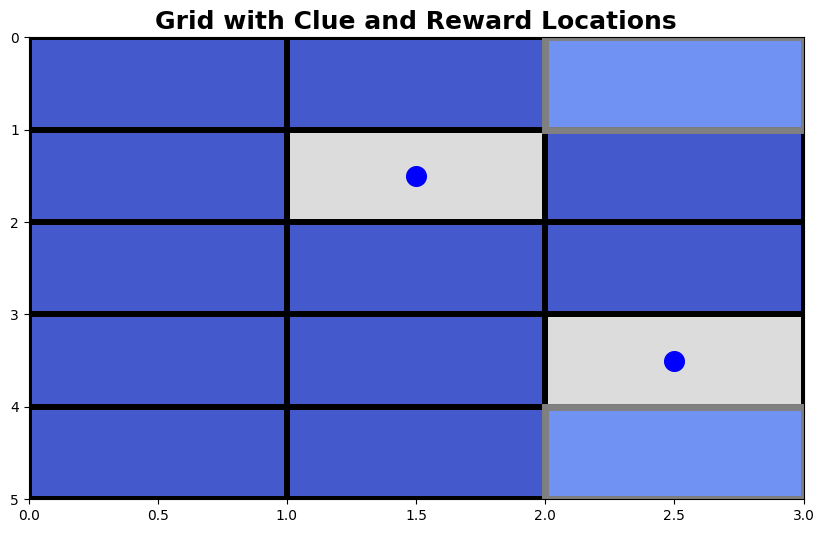

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1] + 1), np.arange(grid_dims[0] + 1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin=0, vmax=30, linewidth=3, cmap='coolwarm')
ax.invert_yaxis()

# Put gray boxes around the possible reward locations
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1], reward_locations[0][0]), 1.0, 1.0, linewidth=5, edgecolor='gray', facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1], reward_locations[1][0]), 1.0, 1.0, linewidth=5, edgecolor='gray', facecolor='none'))

text_offsets = [0.4, 0.6]

clue_grid = np.ones(grid_dims)
for i in range(len(clue_locations)):
  clue_grid[clue_locations[i][0], clue_locations[i][1]] = 15.0
  clue_grid[clue_locations[i][0], clue_locations[i][1]] = 15.0

# Highlight the clue and reward locations
for ii, loc_ii in enumerate(reward_locations):
    row_coord, column_coord = loc_ii
    clue_grid[row_coord, column_coord] = 5.0
    ax.text(column_coord + text_offsets[0], row_coord + text_offsets[1], "", fontsize=15, color='k', fontweight='bold')

# Update the color map array
h.set_array(clue_grid.ravel())

# Plot the clue location
for i in range(len(clue_locations)):
  ax.scatter(clue_locations[i][1] + 0.5, clue_locations[i][0] + 0.5, color='blue', s=200, label="Clue Location", zorder=5)

# Add a legend
# plt.legend()
plt.title("Grid with Clue and Reward Locations", fontsize=18, fontweight='bold')
plt.show()

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()



### The observation model: **A** array

In [4]:
                   # agent loc,     other agent loc, reward_loc
num_states      = [num_grid_points, num_grid_points, len(reward_conditions)]

clue_names      = ['Null', 'reward_on_top', 'reward_on_bottom']
reward_names    = ['Null', 'Cheese', 'Shock']

                  # agent loc,      other agent loc, clue,          , reward
num_obs         = [num_grid_points, num_grid_points, len(clue_names), len(reward_names)]

In [1199]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs]
A = utils.obj_array_zeros(A_m_shapes)

# Agent Location
for i in range(num_grid_points):

    A[0][:, :, i, 0] = np.eye(num_grid_points, num_grid_points)
    A[0][:, :, i, 1] = np.eye(num_grid_points, num_grid_points)

# Other Agent Location
for i in range(num_grid_points):

    A[1][:, i, :, 0] = np.eye(num_grid_points, num_grid_points)
    A[1][:, i, :, 1] = np.eye(num_grid_points, num_grid_points)

# Clue observation
A[2][0, :, :, :] = 1.0

# Both locations needs to be filled for a clue to be observerd
for i, reward_loc in enumerate(reward_locations):

    A[2][0, loc_list.index(clue_locations[0]), loc_list.index(clue_locations[1]), i] = 0.0
    A[2][i+1, loc_list.index(clue_locations[0]), loc_list.index(clue_locations[1]), i] = 1.0

    A[2][0, loc_list.index(clue_locations[1]), loc_list.index(clue_locations[0]), i] = 0.0
    A[2][i+1, loc_list.index(clue_locations[1]), loc_list.index(clue_locations[0]), i] = 1.0

    # A[2][0, loc_list.index(clue_locations[0]), :, i] = 0.0
    # A[2][i+1, loc_list.index(clue_locations[0]), :, i] = 1.0

    # A[2][0, loc_list.index(clue_locations[1]), :, i] = 0.0
    # A[2][i+1, loc_list.index(clue_locations[1]), :, i] = 1.0

# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0, :, :, :] = 1.0

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[3][0, rew_top_idx, :, :] = 0.0
A[3][1, rew_top_idx, :, 0] = 1.0
A[3][2, rew_top_idx, :, 1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" `reward location
A[3][0, rew_bott_idx, :, :] = 0.0
A[3][1, rew_bott_idx, :, 1] = 1.0
A[3][2, rew_bott_idx, :, 0] = 1.0

### The transition model: **B** array

In [1200]:
# initialize `num_controls`
num_controls = [5, 1, 1]

# initialize the shapes of each sub-array `B[f]`
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]

# create the `B` array and fill it out
B = utils.obj_array_zeros(B_f_shapes)

Fill out `B[0]` according to the expected consequences of each of the 5 actions. Note that we also create a list that stores the names of each action, for interpretability.

In [1201]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

# fill out `B[0]` using the 
for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(loc_list):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y 
      next_x = x
    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y 
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x 
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x 
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = loc_list.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

B[1][:,:,0]   = np.full((num_states[1], num_states[1]), 1 / num_states[1])

# Reward location will not change
B[2][:, :, 0] = np.eye(num_states[2])

### Prior preferences: the **C** vectors

In [1202]:
C = utils.obj_array_zeros(num_obs)

C[3][1] = 2.0  # make the agent want to encounter the "Cheese" observation level
C[3][2] = -4.0 # make the agent not want to encounter the "Shock" observation level

### Prior over (initial) hidden states: the **D** vectors

In [1203]:
agent_0_starting_loc = (0, 0)
agent_1_starting_loc = (4, 0)

D_0 = utils.obj_array_uniform(num_states)
D_0[0] = utils.onehot(loc_list.index(agent_0_starting_loc), num_grid_points)

D_1 = utils.obj_array_uniform(num_states)
D_1[0] = utils.onehot(loc_list.index(agent_1_starting_loc), num_grid_points)

## Generative process

### Writing a custom `env` 

In [1204]:
class GridWorldEnv():
    
    def __init__(self, starting_locs = [(0,0), (3,0)], clue_locs = [(1, 1), (3, 1)], reward_condition = 'TOP'):

        self.init_loc_0         = starting_locs[0]
        self.init_loc_1         = starting_locs[1]

        self.current_locations  = [self.init_loc_0, self.init_loc_1]

        self.clue_locs           = clue_locs

        self.reward_condition = reward_condition
    
    def step(self,action_labels):
        
        for i, action_label in enumerate(action_labels):

          (Y, X) = self.current_locations[i]

          if action_label == "UP": 
            
            Y_new = Y - 1 if Y > 0 else Y
            X_new = X

          elif action_label == "DOWN": 

            Y_new = Y + 1 if Y < (grid_dims[0]-1) else Y
            X_new = X

          elif action_label == "LEFT": 
            Y_new = Y
            X_new = X - 1 if X > 0 else X

          elif action_label == "RIGHT": 
            Y_new = Y
            X_new = X +1 if X < (grid_dims[1]-1) else X

          elif action_label == "STAY":
            Y_new, X_new = Y, X 
          
          self.current_locations[i] = (Y_new, X_new)

        loc_obs_0 = self.current_locations[0] 
        loc_obs_1 = self.current_locations[1]

        # Clue Obs

        if self.current_locations[0] == self.clue_locs[0] and self.current_locations[1] == self.clue_locs[1] or self.current_locations[0] == self.clue_locs[1] and self.current_locations[1] == self.clue_locs[0]:
          clue_obs = clue_names[reward_conditions.index(self.reward_condition)+1]
        else:
          clue_obs = 'Null'

          # Reward Obs

        if self.current_locations[0] == reward_locations[0]:
          if self.reward_condition == 'TOP':
            reward_obs_0 = 'Cheese'
          else:
            reward_obs_0 = 'Shock'
        elif self.current_locations[0] == reward_locations[1]:
          if self.reward_condition == 'BOTTOM':
            reward_obs_0 = 'Cheese'
          else:
            reward_obs_0 = 'Shock'
        else:
          reward_obs_0 = 'Null'

        if self.current_locations[1] == reward_locations[0]:
          if self.reward_condition == 'TOP':
            reward_obs_1 = 'Cheese'
          else:
            reward_obs_1 = 'Shock'
        elif self.current_locations[1] == reward_locations[1]:
          if self.reward_condition == 'BOTTOM':
            reward_obs_1 = 'Cheese'
          else:
            reward_obs_1 = 'Shock'
        else:
          reward_obs_1 = 'Null'

        return loc_obs_0, loc_obs_1, clue_obs, reward_obs_0, reward_obs_1

    def reset(self):
        self.current_locations = [self.init_loc_0, self.init_loc_1]
        loc_obs_0 = self.current_locations[0]
        loc_obs_1 = self.current_locations[1]

        if self.current_locations[0] == self.clue_locs[0] and self.current_locations[1] == self.clue_locs[1] or self.current_locations[0] == self.clue_locs[1] and self.current_locations[1] == self.clue_locs[0]:
          clue_obs = clue_names[reward_conditions.index(self.reward_condition)+1]
        else:
          clue_obs = 'Null'
          
        reward_obs = 'Null'

        return loc_obs_0, loc_obs_1, clue_obs, reward_obs, reward_obs

## Active Inference


### Initialize an `Agent` and an instance of `GridWorldEnv`

In [1205]:
agent_0 = Agent(A = A, B = B, C = C, D = D_0, policy_len = 3)
agent_1 = Agent(A = A, B = B, C = C, D = D_1, policy_len = 3)

env     = GridWorldEnv(clue_locs=clue_locations, reward_condition = 'BOTTOM')

loc_0, loc_1, clue_obs, reward_obs_0, reward_obs_1 = env.reset()

### Run an active inference loop over time

In [1206]:
history_of_locs_0 = [loc_0]
history_of_locs_1 = [loc_1]

T = 10 # number of total timestepss

agent_0_obs = [loc_list.index(loc_0), loc_list.index(loc_1), clue_names.index(clue_obs), reward_names.index(reward_obs_0)]
agent_1_obs = [loc_list.index(loc_1), loc_list.index(loc_0), clue_names.index(clue_obs), reward_names.index(reward_obs_1)]

for t in range(T):

    print("-----------")


    qs_0 = agent_0.infer_states(agent_0_obs)
    qs_1 = agent_1.infer_states(agent_1_obs)

    # plot_beliefs(qs_0[2])
    
    agent_0.infer_policies()
    agent_1.infer_policies()

    chosen_action_0_id = agent_0.sample_action()
    chosen_action_1_id = agent_1.sample_action()

    movement_0_id = int(chosen_action_0_id[0])
    movement_1_id = int(chosen_action_1_id[0])

    choice_action_0 = actions[movement_0_id]
    choice_action_1 = actions[movement_1_id]

    print(f'Agent 0: Action at time {t}: {choice_action_0}')
    print(f'Agent 1: Action at time {t}: {choice_action_1}')

    loc_0, loc_1, clue_obs, reward_obs_0, reward_obs_1 = env.step([choice_action_0, choice_action_1])

    agent_0_obs = [loc_list.index(loc_0), loc_list.index(loc_1), clue_names.index(clue_obs), reward_names.index(reward_obs_0)]
    agent_1_obs = [loc_list.index(loc_1), loc_list.index(loc_0), clue_names.index(clue_obs), reward_names.index(reward_obs_1)]

    history_of_locs_0.append(loc_0)
    history_of_locs_1.append(loc_1)

    print(f'Agent 0: Grid location at time {t}: {loc_0}')
    print(f'Agent 1: Grid location at time {t}: {loc_1}')

    print(f'Clue Obs {t}: {clue_obs}')

    print(f'Agent 0: Reward at time {t}: {reward_obs_0}')
    print(f'Agent 1: Reward at time {t}: {reward_obs_1}')


-----------
Agent 0: Action at time 0: DOWN
Agent 1: Action at time 0: UP
Agent 0: Grid location at time 0: (1, 0)
Agent 1: Grid location at time 0: (2, 0)
Clue Obs 0: Null
Agent 0: Reward at time 0: Null
Agent 1: Reward at time 0: Null
-----------
Agent 0: Action at time 1: RIGHT
Agent 1: Action at time 1: RIGHT
Agent 0: Grid location at time 1: (1, 1)
Agent 1: Grid location at time 1: (2, 1)
Clue Obs 1: Null
Agent 0: Reward at time 1: Null
Agent 1: Reward at time 1: Null
-----------
Agent 0: Action at time 2: STAY
Agent 1: Action at time 2: RIGHT
Agent 0: Grid location at time 2: (1, 1)
Agent 1: Grid location at time 2: (2, 2)
Clue Obs 2: Null
Agent 0: Reward at time 2: Null
Agent 1: Reward at time 2: Null
-----------
Agent 0: Action at time 3: STAY
Agent 1: Action at time 3: STAY
Agent 0: Grid location at time 3: (1, 1)
Agent 1: Grid location at time 3: (2, 2)
Clue Obs 3: Null
Agent 0: Reward at time 3: Null
Agent 1: Reward at time 3: Null
-----------
Agent 0: Action at time 4: STAY

### Visualization

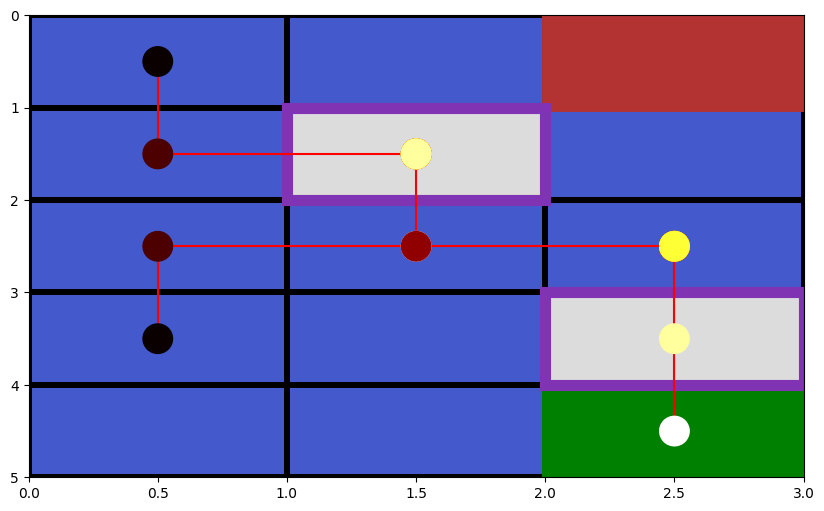

In [1207]:
all_locations_0 = np.vstack(history_of_locs_0).astype(float) # create a matrix containing the agent's Y/X locations over time (each coordinate in one row of the matrix)
all_locations_1 = np.vstack(history_of_locs_1).astype(float) # create a matrix containing the agent's Y/X locations over time (each coordinate in one row of the matrix)

fig, ax = plt.subplots(figsize=(10, 6)) 

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

reward_condition = env.reward_condition
clue_loc_0 = env.clue_locs[0]
clue_loc_1 = env.clue_locs[1]

reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))

reward_loc = reward_locations[0] if reward_condition == "TOP" else reward_locations[1]

if reward_condition == "TOP":
    reward_top.set_edgecolor('g')
    reward_top.set_facecolor('g')
    reward_bottom.set_edgecolor([0.7, 0.2, 0.2])
    reward_bottom.set_facecolor([0.7, 0.2, 0.2])

elif reward_condition == "BOTTOM":
    reward_bottom.set_edgecolor('g')
    reward_bottom.set_facecolor('g')
    reward_top.set_edgecolor([0.7, 0.2, 0.2])
    reward_top.set_facecolor([0.7, 0.2, 0.2])
reward_top.set_zorder(1)
reward_bottom.set_zorder(1)

text_offsets = [0.4, 0.6]
clue_grid = np.ones(grid_dims)
clue_grid[clue_loc_0[0],clue_loc_0[1]] = 15.0
clue_grid[clue_loc_1[0],clue_loc_1[1]] = 15.0
  
h.set_array(clue_grid.ravel())

clue0_rect = ax.add_patch(patches.Rectangle((clue_loc_0[1],clue_loc_0[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))
clue1_rect = ax.add_patch(patches.Rectangle((clue_loc_1[1],clue_loc_1[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))

ax.plot(all_locations_0[:,1]+0.5,all_locations_0[:,0]+0.5, 'r', zorder = 2)
ax.plot(all_locations_1[:,1]+0.5,all_locations_1[:,0]+0.5, 'r', zorder = 2)

temporal_colormap = cm.hot(np.linspace(0,1,T+1))
ax.scatter(all_locations_0[:,1]+0.5,all_locations_0[:,0]+0.5, 450, c = temporal_colormap, zorder=3)
ax.scatter(all_locations_1[:,1]+0.5,all_locations_1[:,0]+0.5, 450, c = temporal_colormap, zorder=3)
plt.show()
